# CatBoost vs LightGBM: simple comparison

In [71]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

In [9]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
# converet target salary into binary variable
df['salary'] = df['salary'].apply(lambda x: 1 if x == ' >50K' else 0)
df['salary'].unique()

array([0, 1], dtype=int64)

## Target Distribution

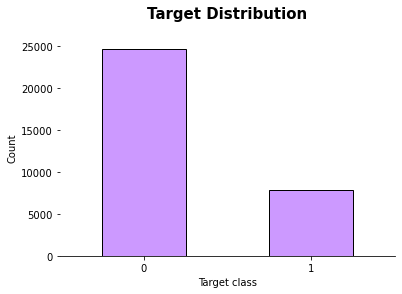

In [28]:
ax = plt.subplot()
df['salary'].value_counts().plot.bar(color = '#cc99ff', edgecolor = 'k')
plt.title('Target Distribution', fontsize = 15, fontweight = 'bold', pad = 20)
ax.set_xlabel('Target class'); ax.set_ylabel('Count')
ax.set_xticklabels(labels = [0, 1], rotation = 0)

for i in ['left', 'right', 'top']:
    ax.spines[i].set_visible(False)

## Feature types
9 categorical variables, 4 continuous/nominal variables -> More categorical variables included in this dataset

In [35]:
def get_age(data):
    if data < 20:
        age = '10s'
    elif data < 30:
        age = '20s'
    elif data < 40:
        age = '30s'
    elif data < 50:
        age = '40s'
    elif data < 60:
        age = '50s'
    elif data < 70:
        age = '60s'
    else:
        age = 'elderly'
        
    return age

In [37]:
df['age'] = df['age'].apply(lambda x: get_age(x))

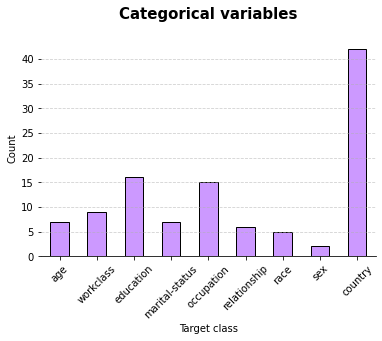

In [45]:
ax = plt.subplot()
df.select_dtypes('object').nunique().plot.bar(color = '#cc99ff', edgecolor = 'k')
plt.title('Categorical variables', fontsize = 15, fontweight = 'bold', pad = 20)
ax.set_xlabel('Target class'); ax.set_ylabel('Count')
ax.set_xticklabels(df.select_dtypes('object').columns, rotation = 45)
ax.grid(axis='y', linestyle='--', alpha = 0.6)

for i in ['left', 'right', 'top']:
    ax.spines[i].set_visible(False)

## CatBoostClassifier

In [88]:
cb = CatBoostClassifier(learning_rate = 0.1,
                         depth = 10,
                         one_hot_max_size = 10,
                         min_data_in_leaf = 5,
                         eval_metric = 'Accuracy')

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

X = df.drop(['salary'], axis = 1)
y = df['salary']
cat_features = df.select_dtypes('object').columns.tolist()

In [89]:
cb_acc_folds = []

for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    
    cb.fit(X_train, 
              y_train, 
              cat_features = cat_features,
              eval_set = (X_test, y_test))
    
    pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    cb_acc_folds.append(acc)

0:	learn: 0.8492399	test: 0.8370950	best: 0.8370950 (0)	total: 62.3ms	remaining: 1m 2s
1:	learn: 0.8533093	test: 0.8438508	best: 0.8438508 (1)	total: 121ms	remaining: 1m
2:	learn: 0.8546146	test: 0.8427760	best: 0.8438508 (1)	total: 184ms	remaining: 1m
3:	learn: 0.8574555	test: 0.8456932	best: 0.8456932 (3)	total: 244ms	remaining: 1m
4:	learn: 0.8588375	test: 0.8467680	best: 0.8467680 (4)	total: 313ms	remaining: 1m 2s
5:	learn: 0.8608338	test: 0.8469215	best: 0.8469215 (5)	total: 375ms	remaining: 1m 2s
6:	learn: 0.8601428	test: 0.8478428	best: 0.8478428 (6)	total: 436ms	remaining: 1m 1s
7:	learn: 0.8609106	test: 0.8507600	best: 0.8507600 (7)	total: 508ms	remaining: 1m 2s
8:	learn: 0.8622927	test: 0.8513742	best: 0.8513742 (8)	total: 576ms	remaining: 1m 3s
9:	learn: 0.8634060	test: 0.8495317	best: 0.8513742 (8)	total: 642ms	remaining: 1m 3s
10:	learn: 0.8635212	test: 0.8516813	best: 0.8516813 (10)	total: 715ms	remaining: 1m 4s
11:	learn: 0.8645961	test: 0.8545985	best: 0.8545985 (11)	to

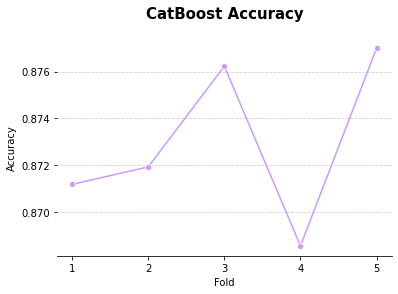

In [90]:
ax = plt.subplot()
sns.lineplot(range(1, 6), acc_folds, marker = 'o', color = '#cc99ff', ax = ax)
plt.title('CatBoost Accuracy', fontsize = 15, fontweight = 'bold', pad = 20)
ax.set_xlabel('Fold'); ax.set_ylabel('Accuracy')
ax.set_xticks([1, 2, 3, 4, 5])
ax.grid(axis='y', linestyle='--', alpha = 0.6)

for i in ['left', 'right', 'top']:
    ax.spines[i].set_visible(False)

## LGBMClassifier

In [82]:
X = pd.get_dummies(X) # one-hot encoding

lgbm = LGBMClassifier(learning_rate = 0.1,
                      max_depth = 10,
                      min_data_in_leaf = 5,
                      num_leaves = 20,
                      n_jobs = -1)

lgbm_acc_folds = []

for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    
    lgbm.fit(X_train, 
             y_train, 
             eval_set = (X_test, y_test),
             early_stopping_rounds = 50,
             eval_metric = 'accuracy')
    
    pred = lgbm.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    lgbm_acc_folds.append(acc)

[1]	valid_0's binary_logloss: 0.51036
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.479365
[3]	valid_0's binary_logloss: 0.454824
[4]	valid_0's binary_logloss: 0.435537
[5]	valid_0's binary_logloss: 0.419745
[6]	valid_0's binary_logloss: 0.405803
[7]	valid_0's binary_logloss: 0.394481
[8]	valid_0's binary_logloss: 0.384418
[9]	valid_0's binary_logloss: 0.375686
[10]	valid_0's binary_logloss: 0.368298
[11]	valid_0's binary_logloss: 0.361395
[12]	valid_0's binary_logloss: 0.355417
[13]	valid_0's binary_logloss: 0.350141
[14]	valid_0's binary_logloss: 0.345603
[15]	valid_0's binary_logloss: 0.34159
[16]	valid_0's binary_logloss: 0.337672
[17]	valid_0's binary_logloss: 0.334139
[18]	valid_0's binary_logloss: 0.330799
[19]	valid_0's binary_logloss: 0.328044
[20]	valid_0's binary_logloss: 0.325561
[21]	valid_0's binary_logloss: 0.32322
[22]	valid_0's binary_logloss: 0.320364
[23]	valid_0's binary_logloss: 0.317963
[24]	valid_0's binary_logloss: 

## Performance comparison
CatBoost better performs than LightGBM if more categorical variables are included in feature set.

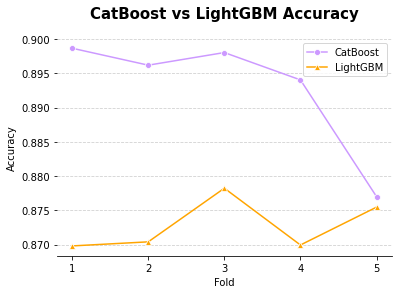

In [93]:
ax = plt.subplot()
sns.lineplot(range(1, 6), cb_acc_folds, marker = 'o', color = '#cc99ff', ax = ax, label = 'CatBoost')
sns.lineplot(range(1, 6), lgbm_acc_folds, marker = '^', color = 'orange', ax = ax, label = 'LightGBM')
plt.title('CatBoost vs LightGBM Accuracy', fontsize = 15, fontweight = 'bold', pad = 20)
ax.set_xlabel('Fold'); ax.set_ylabel('Accuracy')
ax.set_xticks([1, 2, 3, 4, 5])
ax.grid(axis='y', linestyle='--', alpha = 0.6)

for i in ['left', 'right', 'top']:
    ax.spines[i].set_visible(False)